# Basic Sagemaker Pipeline Example - Abalone 

In [1]:
# default_exp abalone

In [2]:
%load_ext autoreload
%autoreload 2

# Import Variables

In [3]:
# export

import logging
import os
import subprocess
import sys
import time
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

In [4]:
# export

bucket = "s3bawspprwe1chatbotunpub01"
dataset_key_prefix = "datasets/abalone"
data_path = f"s3://{bucket}/{dataset_key_prefix}/abalone-dataset.csv"
hyperparameters = {"max_iter": 50}
model_dir = "/tmp/replacewithgenerated"

In [60]:
if not Path(model_dir).exists():
    Path(model_dir).mkdir()

In [5]:
# export

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [51]:
# exportn_step:preprocess


def preprocess(data_path):
    # Since we get a headerless CSV file we specify the column names here.
    feature_columns_names = [
        "sex",
        "length",
        "diameter",
        "height",
        "whole_weight",
        "shucked_weight",
        "viscera_weight",
        "shell_weight",
    ]
    feature_columns_names = [c.lower() for c in feature_columns_names]

    has_additional_dependencies = Path("requirements.txt").exists()
    if has_additional_dependencies:
        logger.info("Installing additional dependencies from requirements.txt")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "-r", "requirements.txt"]
        )
        logger.debug("Installed additional dependencies")

    df = pd.read_csv(data_path)
    # Convert column names ot lwoer case
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

    logger.debug("Defining transformers.")
    numeric_features = list(feature_columns_names)
    numeric_features.remove("sex")
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_features = ["sex"]
    categorical_transformer = Pipeline(
        steps=[
            ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))
        ]
    )
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    logger.info("Applying transforms.")
    y = df["rings"]
    X_pre = df.drop("rings", axis=1)
    X_pre = preprocess.fit_transform(X_pre)
    y_pre = y.to_numpy().reshape(len(y), 1)

    X = np.concatenate((y_pre, X_pre), axis=1)

    logger.info(
        "Splitting %d rows of data into train, validation, test datasets.", len(X)
    )
    np.random.shuffle(X)
    train, validation, test = np.split(X, [int(0.7 * len(X)), int(0.85 * len(X))])

    categorical_mask = [False] * len(numeric_features) + [True] * len(categorical_features)
    columns = ["rings"] + numeric_features + categorical_features
    results = {
        "train": pd.DataFrame(data=train, columns=columns), 
        "validation": pd.DataFrame(data=validation, columns=columns), 
        "test": pd.DataFrame(data=test, columns=columns),
        "categorical_mask": categorical_mask
    }
    return results

In [52]:
# export


def plot_perm_importances(model_dir, model, X, y, dataset_name: str):
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx]
    )
    ax.set_title(f"Permutation Importances: {dataset_name}")
    fig.tight_layout()
    plt.savefig(
        os.path.join(model_dir, f"permutation_importances_{dataset_name}.pdf"),
        dpi=150,
    )

In [65]:
# exportn_step:fit


def fit(model_dir, train, validation, categorical_features, hyperparameters):
    model = HistGradientBoostingRegressor(**hyperparameters, categorical_features=categorical_features)

    logger.debug(f"Using GBM with {model.max_iter} estimators")

    train_data = train.copy()
    y_train = train_data.iloc[:, 0].to_numpy()
    train_data.drop(train_data.columns[0], axis=1, inplace=True)
    X_train = train_data
    logger.debug(f"Training data loaded")

    st = time.time()
    model.fit(X_train, y_train)
    train_time = (time.time() - st) / 60
    logger.info(f"Model trained after: {train_time} minutes")

    validation_data = validation.copy()
    y_val = validation_data.iloc[:, 0].to_numpy()
    validation_data.drop(validation_data.columns[0], axis=1, inplace=True)
    X_val = validation_data
    logger.debug(f"Validation data loaded")

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    logger.debug("Calculating mean squared errors.")
    mse_train = mean_squared_error(y_train, y_pred_train)
    std_train = np.std(y_train - y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)
    std_val = np.std(y_val - y_pred_val)

    logger.debug("Calculated mean squared errors.")
    logger.info(f"Train MSE={mse_train}; Train STD={std_train};")
    logger.info(f"Validation MSE={mse_val}; Validation STD={std_val};")

    plot_perm_importances(model_dir, model, X_train, y_train, "train")
    plot_perm_importances(model_dir, model, X_val, y_val, "validation")

    joblib.dump(model, os.path.join(model_dir, "model.joblib"))
    logger.info("Model persisted to file.")

In [66]:
results = preprocess(data_path)

Applying transforms.
Splitting 4177 rows of data into train, validation, test datasets.


Model trained after: 0.006076546510060629 minutes
Train MSE=2.7415404270470374; Train STD=1.6557597733509042;
Validation MSE=4.748535770697303; Validation STD=2.177493756078126;
Model persisted to file.


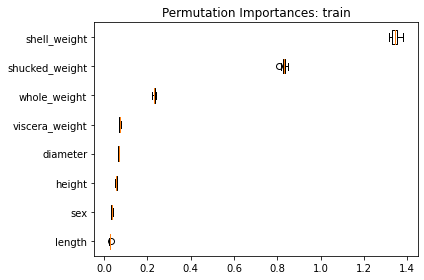

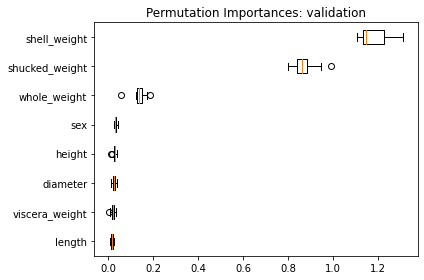

In [68]:
fit(model_dir, results['train'], results['validation'], results['categorical_mask'], hyperparameters)